In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from modelfile.cancer_model import CancerModel
from modelfile.config import Config

from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

In [2]:
def load_pickle(filename):
    
    item_pkl_file = open(filename, 'rb')
    item = pickle.load(item_pkl_file)
    
    return item

In [3]:
config = Config()

## Training data preparation and Data Augmentation

Here we use Keras.ImageDataGenerator to purposely perturbs training examples, changing their appearance slightly, before passing them into the network for training. It is a form of regularization

1. rescale: cast our data from [0, 255] range to [0, 1] range
2. random rotations
3. random zoom
4. width_shift_range:  fraction of total width
5. height_shift_range: fraction of total height
6. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
7. Randomly flip inputs horizontally.
8. Randomly flip inputs vertically.
9. fill_model: One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. Points outside the boundaries of the input are filled according to the given mode:

In [4]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

In [5]:
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [6]:
trainDF = load_pickle("./datasets/trainDF.pickle")
valDF = load_pickle("./datasets/valDF.pickle")
testDF = load_pickle("./datasets/testDF.pickle")


In [7]:
totalTrain = trainDF['label'].count()
totalVal = valDF['label'].count()
totalTest = testDF['label'].count()
classT = [trainDF['label'][trainDF['label']=='0'].count(), trainDF['label'][trainDF['label']=='1'].count()]
classWeight = max(classT) / classT

In [8]:
print(classT)

[168975, 64081]


In [9]:

# initialize the training generator
trainGen = trainAug.flow_from_directory(
    config.TRAIN_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=True,
    batch_size=config.batch_size)

# initialize the validation generator
valGen = valAug.flow_from_directory(
    config.VAL_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=config.batch_size)

# initialize the testing generator
testGen = valAug.flow_from_directory(
    config.TEST_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=config.batch_size)


Found 233056 images belonging to 2 classes.
Found 19500 images belonging to 2 classes.
Found 24968 images belonging to 2 classes.


In [10]:
# initialize our CancerNet model and compile it

model= CancerModel.build(width=48, height=48, depth=3, classes=2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr) 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:
model.summary()

Model: "CancerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 48, 48, 3)]       0         
_________________________________________________________________
ds_conv1 (SeparableConv2D)   (None, 48, 48, 32)        155       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
Relu (TensorFlowOpLayer)     [(None, 48, 48, 32)]      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
ds_conv2 (SeparableConv2D)   (None, 24, 24, 64)        

## Training

In [12]:
# fit the model
history = model.fit_generator(
    trainGen,
    steps_per_epoch=totalTrain // config.batch_size,
    validation_data=valGen,
    validation_steps=totalVal // config.batch_size,
    class_weight=classWeight,
    epochs=config.epochs)

Epoch 1/10
1820/1820 [==============================] - 522s 287ms/step - loss: 0.3523 - accuracy: 0.8494 - val_loss: 1.9521 - val_accuracy: 0.6642
Epoch 2/10
1820/1820 [==============================] - 453s 249ms/step - loss: 0.3207 - accuracy: 0.8636 - val_loss: 1.9917 - val_accuracy: 0.6377
Epoch 3/10
1820/1820 [==============================] - 439s 241ms/step - loss: 0.3120 - accuracy: 0.8677 - val_loss: 1.8580 - val_accuracy: 0.6943
Epoch 4/10
1820/1820 [==============================] - 436s 239ms/step - loss: 0.3049 - accuracy: 0.8707 - val_loss: 0.8049 - val_accuracy: 0.7481
Epoch 5/10
1820/1820 [==============================] - 450s 247ms/step - loss: 0.3005 - accuracy: 0.8728 - val_loss: 1.0761 - val_accuracy: 0.7615
Epoch 6/10
1820/1820 [==============================] - 438s 241ms/step - loss: 0.2964 - accuracy: 0.8746 - val_loss: 0.3805 - val_accuracy: 0.8764
Epoch 7/10
1820/1820 [==============================] - 432s 237ms/step - loss: 0.2931 - accuracy: 0.8761 - val_

## Prediction and Evaluation

In [13]:
# Make prediction
testGen.reset()
prediction = model.predict_generator(testGen, steps=(totalTest // config.batch_size) + 1)

y_pred = np.argmax(prediction, axis=1)

print(classification_report(testGen.classes, y_pred, target_names=testGen.class_indices.keys(), digits = 4))

             precision    recall  f1-score   support

          0     0.8629    0.9378    0.8988     17362
          1     0.8230    0.6600    0.7325      7606

avg / total     0.8508    0.8532    0.8482     24968



In [14]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
# class 0 is negtive, class 1 is positive
c_m = confusion_matrix(testGen.classes, y_pred)
acc = (c_m[0, 0] + c_m[1, 1]) / sum(sum(c_m))
specificity = c_m[0, 0] / (c_m[0, 0] + c_m[0, 1])
sensitivity = c_m[1, 1] / (c_m[1, 0] + c_m[1, 1])

# print the confusion matrix, accuracy, sensitivity, and specificity
print(c_m)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[[16282  1080]
 [ 2586  5020]]
acc: 0.8532
sensitivity: 0.6600
specificity: 0.9378


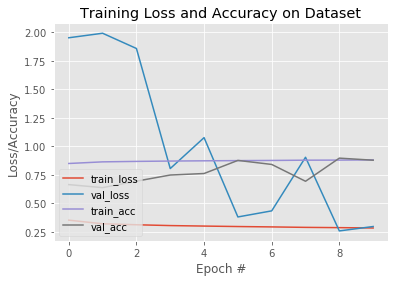

In [15]:
# plot the training loss and accuracy
N = config.epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.plot_name)
